In [2]:
import numpy as np, imp, os, datetime as dt, pandas as pd, matplotlib.pyplot as plt

# Path to folder containing wrapper modules
wrapper_fpath = (r"..\inca.py")
optimize_funs_fpath = (r'..\inca_calibration.py')

wr = imp.load_source('inca',wrapper_fpath)
cf = imp.load_source('inca_calibration', optimize_funs_fpath)

### Set up

In [3]:
wr.initialize('simplyp.dll')
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/tarlandparameters.dat',
                                                            '../../Applications/SimplyP/tarlandinputs.dat')

### Take a look at what is contained in the dataset

In [4]:
print ('Index sets: %s' %dataset.get_index_sets())
print ('Indices in 1st index set: %s' %dataset.get_indexes(dataset.get_index_sets()[0]))
print ('Indices in 2nd index set: %s' %dataset.get_indexes(dataset.get_index_sets()[1]))

Index sets: ['Reaches', 'Landscape units']
Indices in 1st index set: ['Tarland1']
Indices in 2nd index set: ['Arable', 'Improved grassland', 'Semi-natural']


In [5]:
air_temp = dataset.get_input_series('Air temperature',[])
air_temp

array([ 2.91,  4.37,  2.53, ...,  2.01,  1.73,  3.48])

In [6]:
dataset.get_parameter_list()

[('Timesteps', 'uint'),
 ('Start date', 'time'),
 ('Latitude', 'double'),
 ('Initial snow depth', 'double'),
 ('Degree-day factor for snowmelt', 'double'),
 ('Proportion of precipitation that contributes to quick flow', 'double'),
 ('PET reduction factor', 'double'),
 ('Soil field capacity', 'double'),
 ('Baseflow index', 'double'),
 ('Groundwater time constant', 'double'),
 ('Minimum groundwater flow', 'double'),
 ('Gradient of stream velocity-discharge relationship', 'double'),
 ('Exponent of stream velocity-discharge relationship', 'double'),
 ('Catchment area', 'double'),
 ('Reach length', 'double'),
 ('Initial in-stream flow', 'double'),
 ('Soil water time constant', 'double'),
 ('Land use proportions', 'double'),
 ('Reach sediment input scaling factor', 'double'),
 ('Sediment input non-linear coefficient', 'double'),
 ('Day of year when soil erodibility is at its max for spring-grown crops',
  'uint'),
 ('Day of year when soil erodibility is at its max for autumn-grown crops',
  

### Run the model to see what the results look like with manually-calibrated parameters

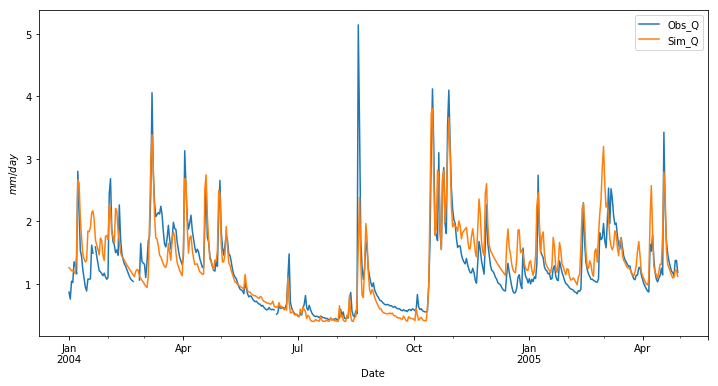

In [8]:
dataset.run_model()

# Read data from the dataset
simQ = dataset.get_result_series('Reach flow (daily mean, mm/day)', ['Tarland1'])
obsQ = dataset.get_input_series('observed Q mm/d', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])
unit = dataset.get_result_unit('Reach flow (daily mean, mm/day)')

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_Q': obsQ, 'Sim_Q': simQ})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.plot(figsize=(12,6), ax=ax)
ax.set_ylabel('$%s$' % unit)
plt.show()

In [9]:
objective = (0, 'Reach flow (daily mean, mm/day)', ['Tarland1'], 'observed Q mm/d', [], 0)
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, mm/day) [Tarland1] vs observed Q mm/d []:
Mean error (bias): 0.053331
Mean absolute error: 0.238949
Mean square error: 0.126155
Nash-Sutcliffe coefficient: 0.698101



### Set up for optimization

Pick out the parameters we want to calibrate, and set initial values for them as well as minimum and maximum limits we want the algorithm to search within.

In [13]:
#NOTE: The 'calibration' structure is a list of (indexed) parameters that we want to calibrate
calibration = [
    ('Degree-day factor for snowmelt',                             []),
    ('Proportion of precipitation that contributes to quick flow', []),
    ('PET reduction factor',                                       []),
    ('Baseflow index',                                             []),
    ('Groundwater time constant',                                  []),
    ('Gradient of stream velocity-discharge relationship',         []),
    ('Exponent of stream velocity-discharge relationship',         []),
    ('Soil water time constant',                                   ['Arable']),
    ('Soil water time constant',                                   ['Semi-natural']),
    ('Soil field capacity',                                        []),
    ('Minimum groundwater flow',                                   []),
    ]

# Read the initial guess provided by the parameter file
initial_guess = cf.default_initial_guess(dataset, calibration)
initial_guess.append(0.5) # Variance of residual error term, also to be optimized

# Set upper and lower limits for parameter values
param_min = [0.1 * x for x in initial_guess]
param_max = [10.0 * x for x in initial_guess]

cf.constrain_min_max(dataset, calibration, param_min, param_max) # NOTE: Constrain to the min and max values recommended
                                                              # by the model in case we made our bounds too wide.

skiptimesteps = 30   # Skip these many of the first timesteps in the objective evaluation

objective = (cf.log_likelyhood, 'Reach flow (daily mean, mm/day)', ['Tarland1'], 'observed Q mm/d', [], skiptimesteps)

In [15]:
calibration

[('Degree-day factor for snowmelt', []),
 ('Proportion of precipitation that contributes to quick flow', []),
 ('PET reduction factor', []),
 ('Baseflow index', []),
 ('Groundwater time constant', []),
 ('Gradient of stream velocity-discharge relationship', []),
 ('Exponent of stream velocity-discharge relationship', []),
 ('Soil water time constant', ['Arable']),
 ('Soil water time constant', ['Semi-natural']),
 ('Soil field capacity', []),
 ('Minimum groundwater flow', [])]

In [14]:
initial_guess

[2.74,
 0.020000000000000004,
 1.0,
 0.7000000000000001,
 65.0,
 0.5,
 0.42000000000000004,
 1.0,
 10.0,
 290.0,
 0.4,
 0.5]

### Run the optimizer and print the results

In [9]:
param_est = run_optimization(dataset, param_min, param_max, initial_guess, calibration, objective, minimize=False)
#param_est = param_est[0]

C:\Users\ljb\Anaconda2\envs\wrapper\lib\site-packages\scipy\stats\_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\ljb\Anaconda2\envs\wrapper\lib\site-packages\scipy\stats\_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


Optimization terminated successfully.
         Current function value: -75.192152
         Iterations: 4244
         Function evaluations: 5928


In [10]:
for idx, cal in enumerate(calibration) :
    name, indexes = cal
    print('Estimated %-60s %-20s %5.2f (range [%5.2f, %5.2f])' %  (name, ', '.join(indexes),
                                                                   param_est[idx],
                                                                   param_min[idx], param_max[idx]))
if len(param_est) > len(calibration) :
    print('M: %f' % param_est[len(calibration)])

Estimated Degree-day factor for snowmelt                                                     1.42 (range [ 0.27,  5.00])
Estimated Proportion of precipitation that contributes to quick flow                         0.04 (range [ 0.00,  0.20])
Estimated PET reduction factor                                                               1.00 (range [ 0.10,  1.00])
Estimated Baseflow index                                                                     0.63 (range [ 0.07,  1.00])
Estimated Groundwater time constant                                                         94.46 (range [ 6.50, 400.00])
Estimated Gradient of stream velocity-discharge relationship                                 0.23 (range [ 0.05,  0.99])
Estimated Exponent of stream velocity-discharge relationship                                 0.23 (range [ 0.10,  0.99])
Estimated Soil water time constant                                     Arable                1.31 (range [ 0.10, 10.00])
Estimated Soil water time const

### Save the optimized parameter values

Write the optimal values back to the dataset, and then generate a new parameter file that has these values

In [11]:
set_values(dataset, param_est, calibration)
dataset.write_parameters_to_file('optimal_parameters.dat')

### Run with optimal parameters and plot

Run the model one more time with the optimal parameters and plot simulated output. Save figure to file, and optionally display it here too.

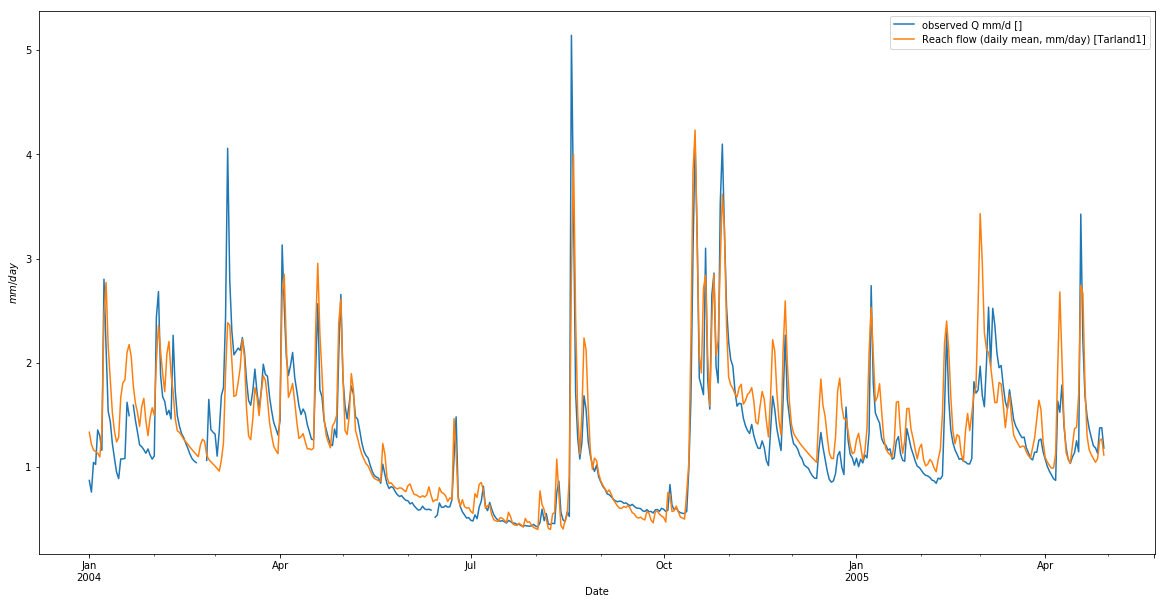

In [12]:
dataset.run_model()
fig, ax = plot_objective(dataset, objective, "simplyp_plots\\optimizer_MAP.png", return_fig=True)
plt.show()

In [13]:
objective = (0, 'Reach flow (daily mean, mm/day)', ['Tarland1'], 'observed Q mm/d', [], 0)
print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, mm/day) [Tarland1] vs observed Q mm/d []:
Mean error (bias): 0.073995
Mean absolute error: 0.210051
Mean square error: 0.097850
Nash-Sutcliffe coefficient: 0.765838



In [ ]:
dataset.delete()